# Exploring different Deep Learning algorithms and comparing their effectiveness in video classification for Word-Level American Sign Language recognition

- hybrid networks (CNN and LSTM model)
- Transformer Model

# Importing needed libraries

In [1]:
from tensorflow import keras
from imutils import paths
from PIL import Image


import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout, Input, Embedding, Bidirectional, LSTM
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, BatchNormalization, LayerNormalization, ConvLSTM2D, MaxPooling3D, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from to_import import *
from to_import import plot_image
%run to_import.py

# Global parameters

In [2]:
WIDTH = 360
HEIGHT = 270

SIZE = (270, 360)
CHANNELS = 1
NBFRAME = 50
BS = 5

# A sample of the data and how it looks like

CSV files outline

In [3]:
train_df = data = pd.read_csv("csvFiles/splitted/Lana.CSV", header = None)
#test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
#print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 106


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
83,1,687,discuss,NaN,2006_10_10,7,NaN,mov/ASL_2006_10_10/scene7-camera1.mov,1824,1855,NaN,NaN,NaN,NaN,1824,1855,3065,1
22,1,216,become,NaN,2006_10_10,3,NaN,mov/ASL_2006_10_10/scene3-camera1.mov,1976,2002,NaN,NaN,NaN,NaN,0,0,0,0
105,1,844,exaggerate,NaN,2006_10_10,8,NaN,mov/ASL_2006_10_10/scene8-camera1.mov,2847,2902,NaN,NaN,NaN,NaN,2847,2902,3089,1
32,1,358,buy,NaN,2006_10_10,4,NaN,mov/ASL_2006_10_10/scene4-camera1.mov,1279,1308,NaN,NaN,NaN,NaN,1279,1308,3024,1
93,1,765,early1,NaN,2006_10_10,8,NaN,mov/ASL_2006_10_10/scene8-camera1.mov,507,523,NaN,NaN,NaN,NaN,507,523,3078,1
44,1,368,call_on_phone,NaN,2006_10_10,5,NaN,mov/ASL_2006_10_10/scene5-camera1.mov,632,649,NaN,NaN,NaN,NaN,632,649,3026,1
78,1,671,dinner1,NaN,2006_10_10,7,NaN,mov/ASL_2006_10_10/scene7-camera1.mov,1165,1206,NaN,NaN,NaN,NaN,1165,1206,3061,1
72,1,679,dirty,NaN,2006_10_10,7,NaN,mov/ASL_2006_10_10/scene7-camera1.mov,396,423,NaN,NaN,NaN,NaN,396,423,3062,1
67,1,607,dance,NaN,2006_10_10,6,NaN,mov/ASL_2006_10_10/scene6-camera1.mov,2230,2274,NaN,NaN,NaN,NaN,2230,2274,3053,1
21,1,192,baseball,NaN,2006_10_10,3,NaN,mov/ASL_2006_10_10/scene3-camera1.mov,1316,1339,NaN,NaN,NaN,NaN,1316,1339,3013,1


Showing frames of the video

In [4]:
cap = cv2.VideoCapture('mov/ASL_2006_10_10/scene2-camera1.mov')
cap.set(1,398)  # Where frame_no is the frame you want
ret, frame = cap.read()  # Read the frame
img1 = frame.copy()
print ('img1 height = ' + str(img1.shape[0]))
print ('img1 width = ' + str(img1.shape[1]))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = crop_center_square(img1)

img1 height = 480
img1 width = 640


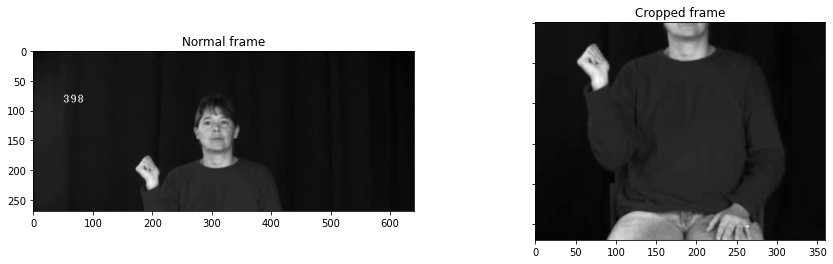

In [5]:
plot_image([img1, img2], cmap='gray', captions=["Normal frame", "Cropped frame"])

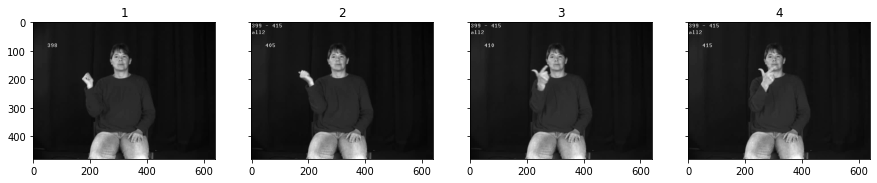

In [6]:
cap = cv2.VideoCapture('mov/ASL_2006_10_10/scene2-camera1.mov')
cap.set(1,398)  # Where frame_no is the frame you want
ret, frame = cap.read()  # Read the frame
img1 = frame.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
cap.set(1,405)
ret, frame = cap.read()
img2 = frame.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
cap.set(1,410)
ret, frame = cap.read()
img3 = frame.copy()
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
cap.set(1,415)
ret, frame = cap.read()
img4 = frame.copy()
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)

plot_image([img1, img2, img3, img4], cmap='gray', captions=["1","2","3","4"])

# Preprocessing the data

In [7]:
x_train = []
y_train = []
maxi = 0
mini = 200
maxi,mini, x_train, y_train = build_dics()   

okay
csvFiles/splitted/Liz.CSV
okay
csvFiles/splitted/Naomi.CSV
okay
csvFiles/splitted/Lana.CSV
okay
csvFiles/splitted/Tyler.CSV
okay
csvFiles/splitted/Dana.CSV


In [8]:
print("max frames: ", maxi)
print("mini frames: ", mini)

max frames:  128
mini frames:  12


In [9]:
len(x_train)
#[[[0.0]*480]*480] * (maxi - len(x_train[i]))

800

In [10]:
%run to_import.py

In [11]:
x_train = padding(x_train)

In [12]:
videos,labels = pre_process(x_train, y_train)
videos = np.array(videos)
labels = np.array(labels)
videos = videos *1./255

In [13]:
videos.shape

(174, 10, 270, 360)

In [14]:
lb = LabelBinarizer()
lb.fit(labels)
labels = lb.transform(labels)

In [15]:
labels.shape

(174, 78)

In [72]:
trainX, validX, trainY, validY = train_test_split(videos,labels, test_size=0.3, train_size=None, random_state=None, shuffle=True, stratify=None)

In [73]:
trainX, testX, trainY, testY = train_test_split(videos,labels, test_size=0.3, train_size=None, random_state=None, shuffle=True, stratify=None)

# CNNLSTM model

In [28]:
CNLS_model = CNNLSTM_model(labels.shape[1])
CNLS_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 10, 268, 358, 3)   444       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 27, 36, 3)    0         
 3D)                                                             
                                                                 
 time_distributed_6 (TimeDis  (None, 10, 27, 36, 3)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 10, 6, 34, 1)      7152      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 10, 6, 4, 1)      0         
 3D)                                                             
                                                      

In [29]:
print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(121, 10, 270, 360)
(121, 78)
(53, 10, 270, 360)
(53, 78)
(53, 10, 270, 360)
(53, 78)


In [30]:
type(trainX)

numpy.ndarray

In [31]:
total_acc = 0
es = EarlyStopping(monitor = 'val_loss', patience = 20, min_delta=0.001, restore_best_weights = True)
ad = tf.keras.optimizers.Adam(
    learning_rate=0.01,
    name='Adam'
)
CNLS_model.compile(loss = 'categorical_crossentropy', optimizer = ad, metrics = ['accuracy'])
for i in range(10):
    

    CNLS_history = CNLS_model.fit(trainX, trainY, 
                              epochs = 50, batch_size = 32, shuffle = True, validation_data = (validX, validY), callbacks = es)
    trainX, testX, trainY, testY = train_test_split(videos,labels, test_size=0.3, train_size=None, random_state=None, shuffle=True, stratify=None)
    predictions = CNLS_model.predict(testX)
    count = 0
    true = 0
    #print(len(testX))
    for i in range(len(predictions)):
        #print(np.argmax(predictions[i]), " ", np.argmax(testY[i]))
        if(np.argmax(predictions[i]) == np.argmax(testY[i])):
            true+=1 
        count +=1
    print("accuracy is: ",true / count * 100, "%")
    total_acc += (true / count * 100)
#print("average accuracy is: ", total_acc/10, "%")

Epoch 1/50
4/4 [==============================] - 9s 935ms/step - loss: 4.3635 - accuracy: 0.0083 - val_loss: 4.3819 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 3s 702ms/step - loss: 4.3415 - accuracy: 0.0248 - val_loss: 4.5688 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 3s 696ms/step - loss: 4.2780 - accuracy: 0.0248 - val_loss: 5.2691 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 3s 696ms/step - loss: 4.2119 - accuracy: 0.0083 - val_loss: 5.4420 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 3s 702ms/step - loss: 4.1726 - accuracy: 0.0413 - val_loss: 5.6039 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 3s 702ms/step - loss: 4.1876 - accuracy: 0.0248 - val_loss: 5.7100 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 3s 707ms/step - loss: 4.1639 - accuracy: 0.0331 - val_loss: 6.0952 - val_accuracy: 0.0

In [32]:
predictions = CNLS_model.predict(testX)

2/2 [==============================] - 0s 117ms/step


In [33]:
count = 0
true = 0
#print(len(testX))
for i in range(len(predictions)):
    #print(np.argmax(predictions[i]), " ", np.argmax(testY[i]))
    if(np.argmax(predictions[i]) == np.argmax(testY[i])):
        true+=1 
    count +=1
print("accuracy is: ",true / count * 100, "%")

accuracy is:  92.45283018867924 %


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


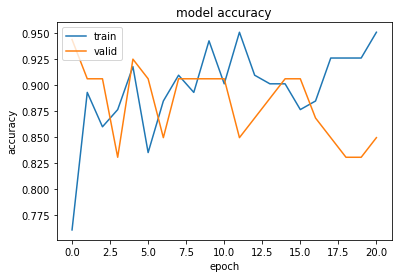

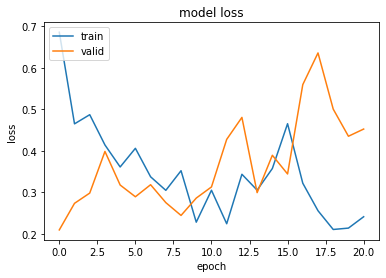

In [34]:
import matplotlib.pyplot as plt
history = CNLS_history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Transformer model

In [35]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


In [53]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [54]:
DATASET_NAME = "ASL"
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (10,270,360,1)
NUM_CLASSES = labels.shape[1]

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [69]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        #x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
                #layers.Dropout(0.2),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)
    representation = layers.Dropout(0.3)(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [74]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Train the model.
    history = model.fit(trainX, trainY, epochs=1000, validation_data=(validX,validY))

    #accuracy, top_5_accuracy = model.evaluate(testX,testY)
    #print(f"Test accuracy: {round(accuracy, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    

    return model

In [75]:
model = run_experiment()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 270, 360, 1)  0         
                             ]                                   
                                                                 
 tubelet_embedding_9 (Tubele  (None, 1485, 128)        65664     
 tEmbedding)                                                     
                                                                 
 positional_encoder_9 (Posit  (None, 1485, 128)        190080    
 ionalEncoder)                                                   
                                                                 
 layer_normalization_123 (La  (None, 1485, 128)        256       
 yerNormalization)                                               
                                                                 
 layer_normalization_124 (La  (None, 1485, 128)        256 

In [ ]:
trainX, testX, trainY, testY = train_test_split(videos,labels, test_size=0.3, train_size=None, random_state=42, shuffle=True, stratify=None)
predictions = model.predict(testX)
count = 0
true = 0
#print(len(testX))
for i in range(len(predictions)):
    #print(np.argmax(predictions[i]), " ", np.argmax(testY[i]))
    if(np.argmax(predictions[i]) == np.argmax(testY[i])):
        true+=1 
    count +=1
print("accuracy is: ",true / count * 100, "%")
print(true, count)


1/2 [==============>...............] - ETA: 0s

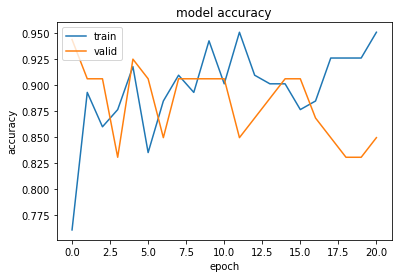

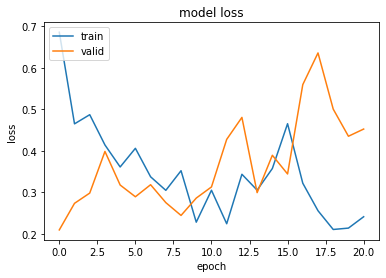

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()